In [ ]:
pip install causalimpact

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.1/470.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.4 MB/s eta 0:00:00
     ━━━━━

In [ ]:
# Import libraries
import numpy as np
import pandas as pd

from causalimpact import CausalImpact

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

import scipy.stats as st

In [ ]:
# SparkSession
spark = SparkSession.builder.getOrCreate()

### Functions

In [ ]:
def posterior_inference_BSTS(alpha: float,
                             inferences: pd.DataFrame,
                             post_period: list) -> pd.DataFrame:
    '''
    Main focus: Compute posterior inferences
    Approach:
    (a) Posterior inference in absolute numbers: Actual (Average), Actual (Cumulative), Predicted (Average), Predicted (Cumulative),95% CI (Average), 95% CI (Cumulative), Absolute Effect (Average), Absolute Effect (Cumulative), 95% CI (Absolute Effect Average), 95% CI (Absolute Effect Cumulative)
    (b) Posterior inference in relative numbers (%): Relative Effect (Average), Relative Effect (Cumulative), 95% CI (Relative Effect Average), 95% CI (Relative Effect Cumulative), P-value, Prob. of Causal Effect
    '''
    alpha = alpha
    confidence = "{}%".format(int((1 - alpha) * 100))
    post_period = post_period
    post_inf = inferences.loc[post_period[0] : post_period[1], :]
    post_point_resp = post_inf.loc[:, "response"]
    post_point_pred = post_inf.loc[:, "point_pred"]
    post_point_upper = post_inf.loc[:, "point_pred_upper"]
    post_point_lower = post_inf.loc[:, "point_pred_lower"]

    mean_resp = post_point_resp.mean()
    mean_resp_fmt = int(mean_resp)
    cum_resp = post_point_resp.sum()
    cum_resp_fmt = int(cum_resp)
    mean_pred = post_point_pred.mean()
    mean_pred_fmt = int(post_point_pred.mean())
    cum_pred = post_point_pred.sum()
    cum_pred_fmt = int(cum_pred)
    mean_lower = post_point_lower.mean()
    mean_lower_fmt = int(mean_lower)
    mean_upper = post_point_upper.mean()
    mean_upper_fmt = int(mean_upper)
    mean_ci_fmt = [mean_lower_fmt, mean_upper_fmt]
    cum_lower = post_point_lower.sum()
    cum_lower_fmt = int(cum_lower)
    cum_upper = post_point_upper.sum()
    cum_upper_fmt = int(cum_upper)
    cum_ci_fmt = [cum_lower_fmt, cum_upper_fmt]

    abs_effect = (post_point_resp - post_point_pred).mean()
    abs_effect_fmt = int(abs_effect)
    cum_abs_effect = (post_point_resp - post_point_pred).sum()
    cum_abs_effect_fmt = int(cum_abs_effect)
    abs_effect_lower = (post_point_resp - post_point_lower).mean()
    abs_effect_lower_fmt = int(abs_effect_lower)
    abs_effect_upper = (post_point_resp - post_point_upper).mean()
    abs_effect_upper_fmt = int(abs_effect_upper)
    abs_effect_ci_fmt = [abs_effect_lower_fmt, abs_effect_upper_fmt]
    cum_abs_lower = (post_point_resp - post_point_lower).sum()
    cum_abs_lower_fmt = int(cum_abs_lower)
    cum_abs_upper = (post_point_resp - post_point_upper).sum()
    cum_abs_upper_fmt = int(cum_abs_upper)
    cum_abs_effect_ci_fmt = [round(cum_abs_lower_fmt, 1), round(cum_abs_upper_fmt, 1)]

    rel_effect = round(abs_effect / mean_pred * 100, 1)
    #rel_effect_fmt = "{:.1f}%".format(rel_effect)
    cum_rel_effect = round(cum_abs_effect / cum_pred * 100, 1)
    #cum_rel_effect_fmt = "{:.1f}%".format(cum_rel_effect)
    rel_effect_lower = abs_effect_lower / mean_pred * 100
    #rel_effect_lower_fmt = "{:.1f}%".format(rel_effect_lower)
    rel_effect_upper = abs_effect_upper / mean_pred * 100
    #rel_effect_upper_fmt = "{:.1f}%".format(rel_effect_upper)
    rel_effect_ci_fmt = [round(rel_effect_lower,1), round(rel_effect_upper,1)] #[rel_effect_lower_fmt, rel_effect_upper_fmt]
    cum_rel_effect_lower = cum_abs_lower / cum_pred * 100
    #cum_rel_effect_lower_fmt = "{:.1f}%".format(cum_rel_effect_lower)
    cum_rel_effect_upper = cum_abs_upper / cum_pred * 100
    #cum_rel_effect_upper_fmt = "{:.1f}%".format(cum_rel_effect_upper)
    cum_rel_effect_ci_fmt = [round(cum_rel_effect_lower, 1), round(cum_rel_effect_upper, 1)] #[cum_rel_effect_lower_fmt, cum_rel_effect_upper_fmt]

    # assuming approximately normal distribution
    # calculate standard deviation from the 95% conf interval
    std_pred = (
        mean_upper - mean_pred
    ) / 1.96  # from mean_upper = mean_pred + 1.96 * std
    # calculate z score
    z_score = (0 - mean_pred) / std_pred
    # pvalue from zscore
    p_value = st.norm.cdf(z_score)
    prob_causal = 1 - p_value
    p_value_perc = round(p_value * 100, 1)
    prob_causal_perc = round(prob_causal * 100, 1)

    # Posterior inference {CausalImpact}
    summary = [
        [mean_resp_fmt, cum_resp_fmt],
        [mean_pred_fmt, cum_pred_fmt],
        [mean_ci_fmt, cum_ci_fmt],
        [" ", " "],
        [abs_effect_fmt, cum_abs_effect_fmt],
        [abs_effect_ci_fmt, cum_abs_effect_ci_fmt],
        [" ", " "],
        [rel_effect, cum_rel_effect], #[rel_effect_fmt, cum_rel_effect_fmt]
        [rel_effect_ci_fmt, cum_rel_effect_ci_fmt],
        [" ", " "],
        [p_value_perc, " "], #["{:.1f}%".format(p_value_perc), " "]
        [prob_causal_perc, " "], #["{:.1f}%".format(prob_causal_perc), " "]
    ]
    summary = pd.DataFrame(
        summary,
        columns=["Average", "Cumulative"],
        index=[
            "Actual",
            "Predicted",
            f"{confidence} CI",
            " ",
            "Absolute Effect",
            f"{confidence} CI Absolute Effect",
            " ",
            "Relative Effect",
            f"{confidence} CI Relative Effect",
            " ",
            "P-value",
            "Prob. of Causal Effect",
        ],
    )
    return summary

In [ ]:
def BSTS_model(data: pd.DataFrame,
               estimation: str = "MLE",
               alpha: float = 0.05) -> pd.DataFrame:
    '''
    Main focus: Applying BSTS modeling to estimate causal effects in time series data for different locations
    Approach: It iterates through unique locations, extracts pre- and post-treatment periods, and utilizes either Maximum Likelihood Estimation (MLE) or Bayesian estimation (pymc) as estimation methods, providing aggregated posterior inferences for causal effects
    '''

    # Create an empty DataFrame to store posterior inferences for all location_id
    results = pd.DataFrame()

    # Get confidence interval
    confidence = f"{int((1 - alpha) * 100)}%"

    # Iterate over each unique location_id values
    for location_id, group in data.groupby('location_id'):

        # Get treatment time
        treatment_time = group['intervention'].iloc[0]
        # Get (total) pre and post treatment values
        pre_treatment_tot, post_treatment_tot = group.loc[group['date'] < treatment_time, 'date'], group.loc[group['date'] >= treatment_time, 'date']
        # Get beginning and end of pre and post period
        pre_period, post_period = [pre_treatment_tot.min(), pre_treatment_tot.max()], [post_treatment_tot.min(), post_treatment_tot.max()]
        # Reset index as date
        group.index = group['date']
        # Drop location_id, date and intervention before applying causalimpact
        group.drop(['location_id', 'date', 'intervention'], inplace=True, axis=1)

        # Condition: type of estimation
        if estimation == 'MLE':
            # Apply causalimpact with MLE as estimation method
            impact = CausalImpact(group, pre_period, post_period)
            impact.run()

        elif estimation == 'pymc':
            # Apply causalimpact with pymc as estimation method --> Only works with ONE exogenous variable
            # TODO: Before applying causalimpact must get rid of all the exogenous variables but one
            impact = CausalImpact(group, pre_period, post_period, estimation=estimation)
            impact.run()

        # Get posterior inferences
        summary = posterior_inference_BSTS(alpha=alpha, inferences=impact.inferences, post_period=post_period)

        # Concatenate posterior inference values for current location with results dataframe
        location_results = pd.DataFrame([{
            'location_id': location_id,
            'Actual (Average)': summary.loc['Actual', 'Average'],
            'Actual (Cumulative)': summary.loc['Actual', 'Cumulative'],
            'Predicted (Average)': summary.loc['Predicted', 'Average'],
            'Predicted (Cumulative)': summary.loc['Predicted', 'Cumulative'],
            f'{confidence} CI (Average)': summary.loc[f'{confidence} CI', 'Average'],
            f'{confidence} CI (Cumulative)': summary.loc[f'{confidence} CI', 'Cumulative'],
            'Absolute Effect (Average)': summary.loc['Absolute Effect', 'Average'],
            'Absolute Effect (Cumulative)': summary.loc['Absolute Effect', 'Cumulative'],
            f'{confidence} CI (Absolute Effect Average)': summary.loc[f'{confidence} CI Absolute Effect', 'Average'],
            f'{confidence} CI (Absolute Effect Cumulative)': summary.loc[f'{confidence} CI Absolute Effect', 'Cumulative'],
            'Relative Effect (Average)': summary.loc['Relative Effect', 'Average'],
            'Relative Effect (Cumulative)': summary.loc['Relative Effect', 'Cumulative'],
            f'{confidence} CI (Relative Effect Average)': summary.loc[f'{confidence} CI Relative Effect', 'Average'],
            f'{confidence} CI (Relative Effect Cumulative)': summary.loc[f'{confidence} CI Relative Effect', 'Cumulative'],
            'P-value': summary.loc['P-value', 'Average'],
            'Prob. of Causal Effect': summary.loc['Prob. of Causal Effect', 'Average']
        }])

        # Concatenate posterior inference values for current location with results
        results = pd.concat([results, location_results], ignore_index=True)

    # Return the posterior inference values for each locaion_
    return results

### Bayesian Structural Time Series model (causalimpact by jamalsenouci)

**Causal Inference problem**: Figuring out the effect of the usage of Eliq’s solution on energy consumption - Do Eliq’s energy management solutions cause changes (decrease) in energy consumptions?

**Goal**: Eliq's energy management solutions decrease energy consumption.

**Model**: Structural time-series models are state-space models for time-series data, and the components are:
* Local Level Model (default), it is built by using a noise *e*, a random walk (level) and the linear regression (*beta.X*)
*

**Estimation method**:  *MLE* or *Bayesian inference* (pymc)

**Hypothesis testing**:
* *Null hypothesis (H_0)* : There is signal in the observed data + No (causal) impact
* *Alternative hypothesis (H_1)* : There is no signal in the observed data + Presence of a causal impact/effect

**P-value** (1)(2): The computation follows the idea of simulating with the fitted parameters several time series for the post-intervention period and counting how many either surpass the total summation of `y` (positive relative effect) or how many falls under its summation (negative relative effect).\
*Inputs* are the forecast simulations for value of `y` extracted from `P(z | y)`, while the *output* represents the likelihood of obtaining the observed data by random chance.\
*Interpretation*: It's the probability of having a causal effect (and not just noise). In details, it revolves around whether the observed response deviates significantly from what would be expected under H_0, indicating the presence or absence of an intervention/impact effect. A p-value below the level of significance (ie 0.05) - we reject the H_0 - it suggests that the observed response is significantly different from what would be expected in the absence of intervention.

**Expected result**: Negative effect after the intervention period is statistically significant.

**Interpretation** (3): It indicates a decrease in energy consumption during the intervention period, which aligns with the objective of reducing energy consumption. The statistically significant negative effect suggests that the observed decrease in energy consumption is unlikely to be due to chance

*References*:
1. https://github.com/WillianFuks/tfcausalimpact/issues/54
2. https://github.com/WillianFuks/tfcausalimpact/issues/73
3. https://github.com/WillianFuks/tfcausalimpact/issues/72

In [ ]:
'''
Issues with causalimpact:
1. Why confidence intervals are wide(r than original Google's R version)? It might be due to the R version placing an upper limit on the standard deviation
2. Calculation error of p-value: the current p-value is calculated by the mean value of the synthetic control group's predictor rather than the point effect value
3. Apply causalimpact with pymc as estimation method --> Only works with ONE exogenous variable
'''

In [ ]:
# Load jersey data
table_name = 'eliqdatalake.playground.jersey_data'
query = f"SELECT * FROM {table_name}"
data = spark.sql(query).toPandas().sort_values(['location_id', 'date']).reset_index(drop=True)

In [ ]:
# TODO: Go back to preprocessing phase and add condition to check the presence of zero-values --> ex 1840990 ==> DONE in handling_missing()
d = [loc_id for loc_id, group in data.groupby('location_id') if (group['energy']==0).sum()/len(group) >= 0.2]
for location_id in d:
    data.drop(data.query(f'location_id=={location_id}').index, inplace=True)
data.reset_index(drop=True, inplace=True)

In [ ]:
# Drop differentiated columns since BSTS can handle structural changes in the data
data.drop(['energy_diff', 'temp_diff', 'cloudcover_diff', 'humidity_diff', 'precip_diff', 'windspeed_diff', 'brightness_s2s_diff'], inplace=True, axis=1)

In [ ]:
data

,location_id,date,intervention,energy,temp,cloudcover,humidity,precip,windspeed,brightness_s2s
0,1420037,2020-09-20,2021-09-20,9429.0,18.6,17.0,86.0,0.0,12.2,0.41
1,1420037,2020-09-21,2021-09-20,10173.0,18.9,11.0,84.0,0.0,12.5,0.41
2,1420037,2020-09-22,2021-09-20,7932.0,17.1,42.0,93.0,0.0,13.5,0.40
3,1420037,2020-09-23,2021-09-20,7901.0,15.3,38.0,84.0,0.1,28.0,0.40
4,1420037,2020-09-24,2021-09-20,8638.0,12.5,36.0,77.0,0.2,40.4,0.40
...,...,...,...,...,...,...,...,...,...,...
3663036,6404010,2023-04-22,2022-04-26,15038.0,10.3,52.0,86.0,0.0,18.0,0.52
3663037,6404010,2023-04-23,2022-04-26,19145.0,10.1,69.0,92.0,0.0,23.4,0.52
3663038,6404010,2023-04-24,2022-04-26,8908.0,9.9,47.0,85.0,0.0,22.8,0.53
3663039,6404010,2023-04-25,2022-04-26,9144.0,8.8,46.0,75.0,0.0,21.2,0.53


In [ ]:
# Apply Bayesian Structural Time Series model (by causalimpact)
results = BSTS_model(data)

1. 1420037 done
2. 1420043 done
3. 1420059 done
4. 1420066 done
5. 1420072 done
6. 1420073 done
7. 1420076 done
8. 1420086 done
9. 1420088 done
10. 1420089 done
11. 1420090 done
12. 1420092 done
13. 1420099 done
14. 1420102 done
15. 1420107 done
16. 1420114 done
17. 1420117 done
18. 1420118 done
19. 1420120 done
20. 1420122 done
21. 1420125 done
22. 1420128 done
23. 1420131 done
24. 1420134 done
25. 1420138 done
26. 1420141 done
27. 1420144 done
28. 1420146 done
29. 1420147 done
30. 1420150 done
31. 1420151 done
32. 1420154 done
33. 1420162 done
34. 1420165 done
35. 1420167 done
36. 1420170 done
37. 1420179 done
38. 1420186 done
39. 1420191 done
40. 1420202 done
41. 1420203 done
42. 1420227 done
43. 1420235 done
44. 1420240 done
45. 1420242 done
46. 1420243 done
47. 1420248 done
48. 1420250 done
49. 1420258 done
50. 1420259 done
51. 1420279 done
52. 1420283 done
53. 1420290 done
54. 1420297 done
55. 1420306 done
56. 1420311 done
57. 1420327 done
58. 1420330 done
59. 1420332 done
60. 14

/databricks/python/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1278. 1803333 done
1279. 1803352 done
1280. 1803354 done
1281. 1803356 done
1282. 1803367 done
1283. 1803376 done
1284. 1803386 done
1285. 1803387 done
1286. 1803388 done
1287. 1803398 done
1288. 1803408 done
1289. 1803419 done
1290. 1803424 done
1291. 1803428 done
1292. 1803431 done
1293. 1803437 done
1294. 1803440 done
1295. 1803446 done
1296. 1803450 done
1297. 1803458 done
1298. 1803461 done
1299. 1803463 done
1300. 1803469 done
1301. 1803470 done
1302. 1803479 done
1303. 1803490 done
1304. 1803491 done
1305. 1803494 done
1306. 1803498 done
1307. 1803510 done
1308. 1803515 done
1309. 1803517 done
1310. 1803522 done
1311. 1803528 done
1312. 1803530 done
1313. 1803532 done
1314. 1803537 done
1315. 1803545 done
1316. 1803560 done
1317. 1803562 done
1318. 1803563 done
1319. 1803571 done
1320. 1803576 done
1321. 1803598 done
1322. 1803600 done
1323. 1803611 done
1324. 1803612 done
1325. 1803614 done
1326. 1803617 done
1327. 1803621 done
1328. 1803622 done
1329. 1803623 done
1330. 180363

/databricks/python/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2153. 1808111 done
2154. 1808115 done
2155. 1808117 done
2156. 1808120 done
2157. 1808131 done
2158. 1808133 done
2159. 1808136 done
2160. 1808160 done
2161. 1808167 done
2162. 1808169 done
2163. 1808173 done
2164. 1808174 done
2165. 1808176 done
2166. 1808184 done
2167. 1808195 done
2168. 1808215 done
2169. 1808220 done
2170. 1808230 done
2171. 1808233 done
2172. 1808235 done
2173. 1808236 done
2174. 1808237 done
2175. 1808239 done
2176. 1808243 done
2177. 1808246 done
2178. 1808248 done
2179. 1808249 done
2180. 1808251 done
2181. 1808252 done
2182. 1808259 done
2183. 1808276 done
2184. 1808279 done
2185. 1808285 done
2186. 1808286 done
2187. 1808299 done
2188. 1808310 done
2189. 1808324 done
2190. 1808326 done
2191. 1808328 done
2192. 1808334 done
2193. 1808342 done
2194. 1808343 done
2195. 1808353 done
2196. 1808360 done
2197. 1808362 done
2198. 1808363 done
2199. 1808369 done
2200. 1808370 done
2201. 1808371 done
2202. 1808372 done
2203. 1808373 done
2204. 1808396 done
2205. 180840

/databricks/python/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4159. 1840762 done
4160. 1840767 done
4161. 1840768 done
4162. 1840772 done
4163. 1840773 done
4164. 1840776 done
4165. 1840783 done
4166. 1840794 done
4167. 1840800 done
4168. 1840805 done
4169. 1840806 done
4170. 1840821 done
4171. 1840824 done
4172. 1840831 done
4173. 1840852 done
4174. 1840853 done
4175. 1840861 done
4176. 1840865 done
4177. 1840876 done
4178. 1840890 done
4179. 1840899 done
4180. 1840902 done
4181. 1840903 done
4182. 1840905 done
4183. 1840914 done
4184. 1840926 done
4185. 1840929 done
4186. 1840938 done
4187. 1840943 done
4188. 1840948 done
4189. 1840961 done
4190. 1840962 done
4191. 1840967 done
4192. 1840972 done
4193. 1840977 done
4194. 1840988 done
4195. 1840992 done
4196. 1840994 done
4197. 1840996 done
4198. 1840997 done
4199. 1841003 done
4200. 1841005 done
4201. 1841009 done
4202. 1841013 done
4203. 1841019 done
4204. 1841026 done
4205. 1841040 done
4206. 1841045 done
4207. 1841049 done
4208. 1841052 done
4209. 1841058 done
4210. 1841060 done
4211. 184106

In [ ]:
results

,location_id,Actual (Average),Actual (Cumulative),Predicted (Average),Predicted (Cumulative),95% CI (Average),95% CI (Cumulative),Absolute Effect (Average),Absolute Effect (Cumulative),95% CI (Absolute Effect Average),95% CI (Absolute Effect Cumulative),Relative Effect (Average),Relative Effect (Cumulative),95% CI (Relative Effect Average),95% CI (Relative Effect Cumulative),P-value,Prob. of Causal Effect
0,1420037,9384,3434891,9505,3478838,"[6315, 12694]","[2311375, 4646300]",-120,-43947,"[3069, -3309]","[1123515, -1211409]",-1.3,-1.3,"[32.3, -34.8]","[32.3, -34.8]",0.0,100.0
1,1420043,8520,3118457,8588,3143212,"[1999, 15176]","[731971, 5554453]",-67,-24755,"[6520, -6655]","[2386485, -2435996]",-0.8,-0.8,"[75.9, -77.5]","[75.9, -77.5]",0.5,99.5
2,1420059,13370,4893747,11099,4062301,"[669, 21528]","[245063, 7879539]",2271,831445,"[12701, -8157]","[4648683, -2985792]",20.5,20.5,"[114.4, -73.5]","[114.4, -73.5]",1.8,98.2
3,1420066,10535,3856093,12088,4424384,"[5628, 18548]","[2060169, 6788600]",-1552,-568291,"[4906, -8012]","[1795923, -2932507]",-12.8,-12.8,"[40.6, -66.3]","[40.6, -66.3]",0.0,100.0
4,1420072,16104,5894308,10625,3888998,"[-53579, 74830]","[-19610112, 27388109]",5478,2005309,"[69684, -58726]","[25504420, -21493801]",51.6,51.6,"[655.8, -552.7]","[655.8, -552.7]",37.3,62.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5006,5481719,549,200991,579,212055,"[24, 1134]","[9051, 415058]",-30,-11064,"[524, -584]","[191939, -214067]",-5.2,-5.2,"[90.5, -100.9]","[90.5, -100.9]",2.0,98.0
5007,5651511,6734,2464785,17136,6271935,"[-43100, 77372]","[-15774605, 28318476]",-10402,-3807150,"[49834, -70638]","[18239390, -25853691]",-60.7,-60.7,"[290.8, -412.2]","[290.8, -412.2]",28.9,71.1
5008,6061367,6740,2467173,13324,4876705,"[-30968, 57616]","[-11334344, 21087755]",-6583,-2409531,"[37709, -50875]","[13801518, -18620581]",-49.4,-49.4,"[283.0, -381.8]","[283.0, -381.8]",27.8,72.2
5009,6377801,19720,7217540,16115,5898178,"[-958, 33189]","[-350883, 12147241]",3604,1319361,"[20678, -13469]","[7568424, -4929700]",22.4,22.4,"[128.3, -83.6]","[128.3, -83.6]",3.2,96.8


In [ ]:
# Get statistically significant (p-value <= 5%) of locations
statistically_significant = results.groupby('location_id').filter(lambda group: (group['P-value'] <= 5.0).any())['location_id'].unique().tolist()
results_statistically_significant = results[results['location_id'].isin(statistically_significant)].copy().reset_index(drop=True)

In [ ]:
results_statistically_significant

,location_id,Actual (Average),Actual (Cumulative),Predicted (Average),Predicted (Cumulative),95% CI (Average),95% CI (Cumulative),Absolute Effect (Average),Absolute Effect (Cumulative),95% CI (Absolute Effect Average),95% CI (Absolute Effect Cumulative),Relative Effect (Average),Relative Effect (Cumulative),95% CI (Relative Effect Average),95% CI (Relative Effect Cumulative),P-value,Prob. of Causal Effect
0,1420037,9384,3434891,9505,3478838,"[6315, 12694]","[2311375, 4646300]",-120,-43947,"[3069, -3309]","[1123515, -1211409]",-1.3,-1.3,"[32.3, -34.8]","[32.3, -34.8]",0.0,100.0
1,1420043,8520,3118457,8588,3143212,"[1999, 15176]","[731971, 5554453]",-67,-24755,"[6520, -6655]","[2386485, -2435996]",-0.8,-0.8,"[75.9, -77.5]","[75.9, -77.5]",0.5,99.5
2,1420059,13370,4893747,11099,4062301,"[669, 21528]","[245063, 7879539]",2271,831445,"[12701, -8157]","[4648683, -2985792]",20.5,20.5,"[114.4, -73.5]","[114.4, -73.5]",1.8,98.2
3,1420066,10535,3856093,12088,4424384,"[5628, 18548]","[2060169, 6788600]",-1552,-568291,"[4906, -8012]","[1795923, -2932507]",-12.8,-12.8,"[40.6, -66.3]","[40.6, -66.3]",0.0,100.0
4,1420073,12025,4401233,12286,4496973,"[5092, 19481]","[1863705, 7130241]",-261,-95739,"[6933, -7456]","[2537527, -2729007]",-2.1,-2.1,"[56.4, -60.7]","[56.4, -60.7]",0.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1897,4892748,8503,3112300,9965,3647329,"[1249, 18681]","[457163, 6837496]",-1461,-535029,"[7254, -10178]","[2655136, -3725196]",-14.7,-14.7,"[72.8, -102.1]","[72.8, -102.1]",1.3,98.7
1898,5481718,673,246472,705,258358,"[286, 1125]","[104771, 411944]",-32,-11886,"[387, -452]","[141700, -165472]",-4.6,-4.6,"[54.8, -64.0]","[54.8, -64.0]",0.0,100.0
1899,5481719,549,200991,579,212055,"[24, 1134]","[9051, 415058]",-30,-11064,"[524, -584]","[191939, -214067]",-5.2,-5.2,"[90.5, -100.9]","[90.5, -100.9]",2.0,98.0
1900,6377801,19720,7217540,16115,5898178,"[-958, 33189]","[-350883, 12147241]",3604,1319361,"[20678, -13469]","[7568424, -4929700]",22.4,22.4,"[128.3, -83.6]","[128.3, -83.6]",3.2,96.8


In [ ]:
results_statistically_significant.loc[:, results_statistically_significant.columns != 'location_id'].describe()

,Actual (Average),Actual (Cumulative),Predicted (Average),Predicted (Cumulative),Absolute Effect (Average),Absolute Effect (Cumulative),Relative Effect (Average),Relative Effect (Cumulative),P-value,Prob. of Causal Effect
count,1902.000000,1.902000e+03,1902.000000,1.902000e+03,1902.000000,1.902000e+03,1902.000000,1902.000000,1902.000000,1902.000000
mean,21233.279180,7.771563e+06,24347.916930,8.911518e+06,-3114.395899,-1.139955e+06,-8.895110,-8.895110,1.226288,98.773712
std,14883.889866,5.447507e+06,17997.843342,6.587207e+06,6607.533242,2.418438e+06,17.378132,17.378132,1.475496,1.475496
min,118.000000,4.331900e+04,128.000000,4.712600e+04,-102860.000000,-3.764712e+07,-73.100000,-73.100000,0.000000,95.000000
25%,11821.000000,4.326794e+06,12660.000000,4.633630e+06,-4689.250000,-1.716396e+06,-18.775000,-18.775000,0.000000,97.800000
50%,17572.500000,6.431721e+06,19348.500000,7.081770e+06,-1381.000000,-5.056100e+05,-8.300000,-8.300000,0.500000,99.500000
75%,26564.250000,9.722697e+06,30916.750000,1.131579e+07,66.500000,2.438300e+04,0.400000,0.400000,2.200000,100.000000
max,192982.000000,7.063150e+07,222146.000000,8.130552e+07,42035.000000,1.538516e+07,141.000000,141.000000,5.000000,100.000000


In [ ]:
# Compute confidence interval 95% values
columns = ['95% CI (Average)', '95% CI (Cumulative)', '95% CI (Absolute Effect Average)','95% CI (Absolute Effect Cumulative)','95% CI (Relative Effect Average)']
for col in columns:
    print(f'(Avg) {col}', results_statistically_significant[col].apply(pd.Series).mean().astype(int).tolist() )

(Avg) 95% CI (Average) [5041, 43654]
(Avg) 95% CI (Cumulative) [1845330, 15977705]
(Avg) 95% CI (Absolute Effect Average) [16191, -22420]
(Avg) 95% CI (Absolute Effect Cumulative) [5926231, -8206142]
(Avg) 95% CI (Relative Effect Average) [67, -85]


In [ ]:
# Compute the median values
columns = ['Actual (Average)', 'Predicted (Average)', 'Absolute Effect (Average)', 'Relative Effect (Average)', 'P-value']
for col in columns:
    print(f'Median for {col}', results_statistically_significant[col].sort_values().median())

Median for Actual (Average) 17572.5
Median for Predicted (Average) 19348.5
Median for Absolute Effect (Average) -1381.0
Median for Relative Effect (Average) -8.3
Median for P-value 0.5


**Summary of statistically significant locations with maximum likelihood estimation (causalimpact)**:
---
* **Statistically significant locations** are *1902* out of 5011, indicating that approx. 37% of the locations have a significant (negative or positive) impact

*Average* results:
* **Actual energy consumption (observed)** is approx 21,233 wh (21 kwh) - median is 17,572 wh (17 kwh), while **predicted energy consumption (counterfactual)** is approx 24,347 wh (24 kwh) - median is 19,348 wh (19 kwh) , with **variability** of 17,997 wh (17 kwh) and **95% confidence interval** of [5041, 43654]
* **Absolute effect** is -3,114 wh (-3 kwh), with **variability** of 6,607 wh (6 kwh) and **95% confidence interval** of [16191, -22420]
* **Relative effect** of around -9\%, precisely -8.9\%, (median -8.3\%) indicating a negative effect ('minus´ symbol), ie decrease in energy consumption. **Variability** is around 17\%, with -18\% and -0.4\% as **25th** and **75th percentiles**, respectively. The **95% confidence interval** is [67\%, -85\%] which is large. \
Interpretation: The large post-treatment period (and extreme positive and negative values) adds uncertainty and variation to the data, although it is over the long term that we begin to see a clear (less accurate) negative effect trend --> more covariates can help to predict energy consumption + less post-treatment period, we would get less variation and less negative effect

*Cumulative* results:
* **Actual energy consumption (observed)** is approx 7,771,563 wh (7,771 kwh), while **predicted energy consumption (counterfactual)** is approx 8,911,518 wh (8,911 kwh), with **variability** of 6,587,207 wh (6,587 kwh) and **95% confidence interval** of [1845330, 15977705]
* **Absolute effect** is -1,139,955 wh (-1,139 kwh), with **variability** of 2,418,438 wh (2,418 kwh) and **95% confidence interval** of [5926231, -8206142]

NB. "Statistically significant locations" means that their p-value <= 5\%

**Example: (avg) relative effect -8.0%**
--

/root/.ipykernel/1137/command-233991557695339-1712678866:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff.drop(['location_id', 'date', 'intervention'], inplace=True, axis=1)


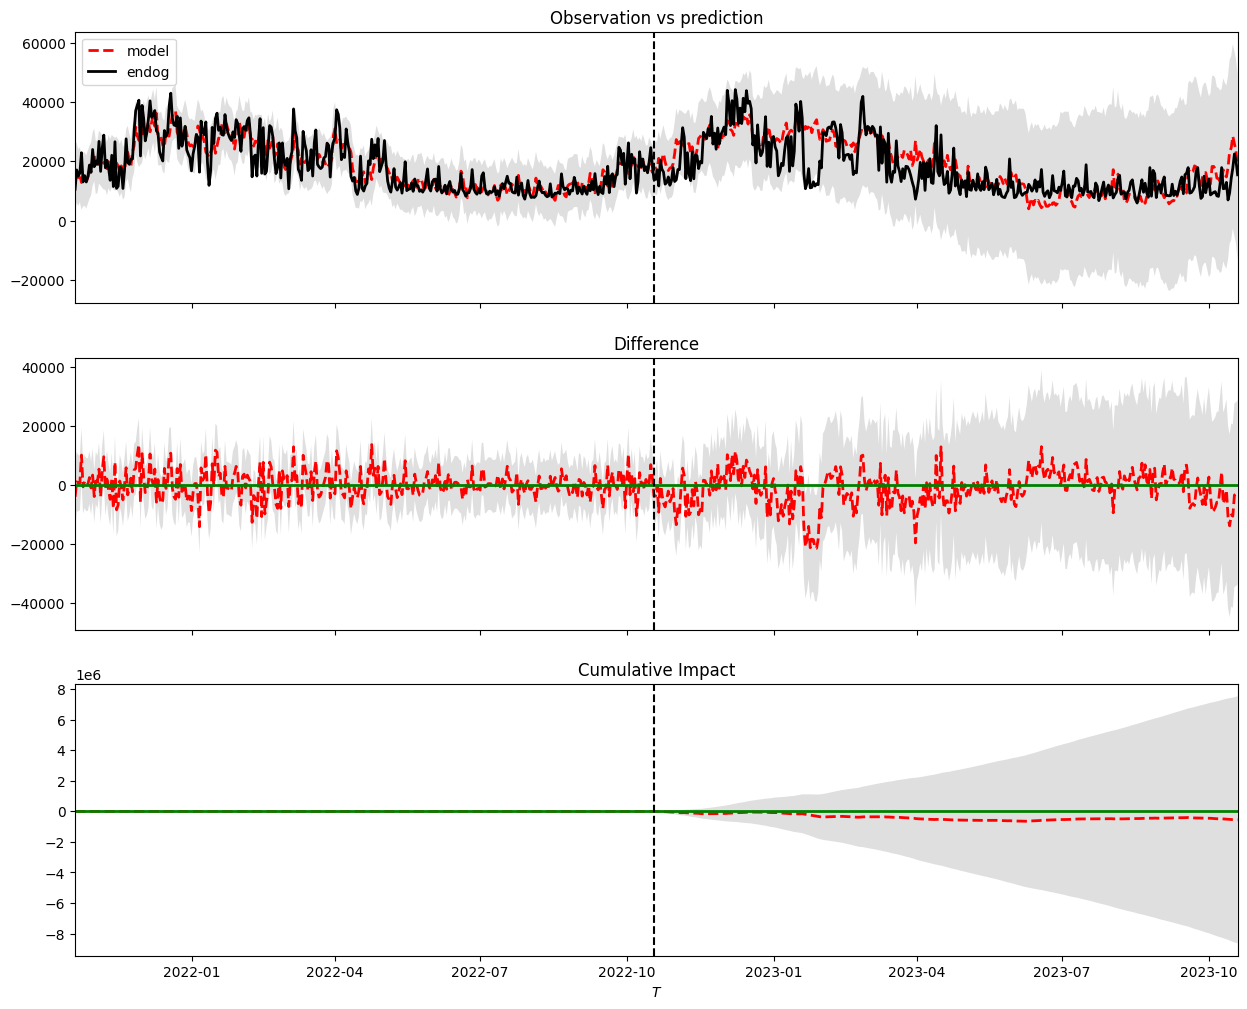

In [ ]:
df_diff = data.query(f'location_id=={2566400}')
df_diff.index = df_diff['date']
treatment_time = df_diff['intervention'].iloc[0]
pre_period_temp,post_period_temp  = df_diff[df_diff['date'] < treatment_time]['date'], df_diff[df_diff['date'] >= treatment_time]['date']
pre_period, post_period = [pre_period_temp.min(), pre_period_temp.max()], [post_period_temp.min(), post_period_temp.max()]
df_diff.drop(['location_id', 'date', 'intervention'], inplace=True, axis=1)
impact = CausalImpact(df_diff, pre_period, post_period)
impact.run()
impact.plot()

In [ ]:
impact.summary()

                                  Average            Cumulative
Actual                              17405               6370527
Predicted                           18919               6924704
95% CI                     [-3182, 41022]  [-1164912, 15014321]
                                                               
Absolute Effect                     -1514               -554176
95% CI                    [20588, -23616]   [7535440, -8643793]
                                                               
Relative Effect                     -8.0%                 -8.0%
95% CI                  [108.8%, -124.8%]     [108.8%, -124.8%]
                                                               
P-value                              4.7%                      
Prob. of Causal Effect              95.3%                      


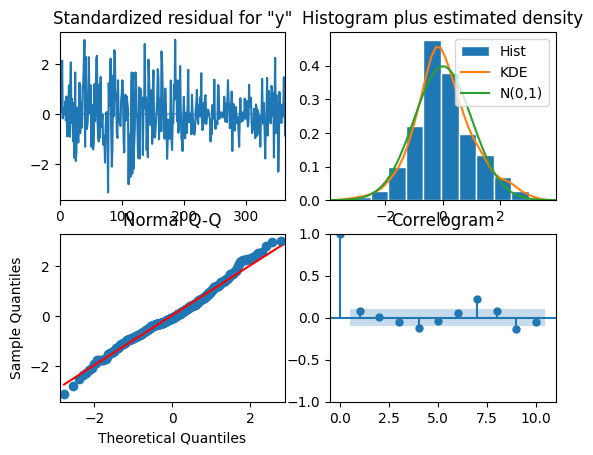

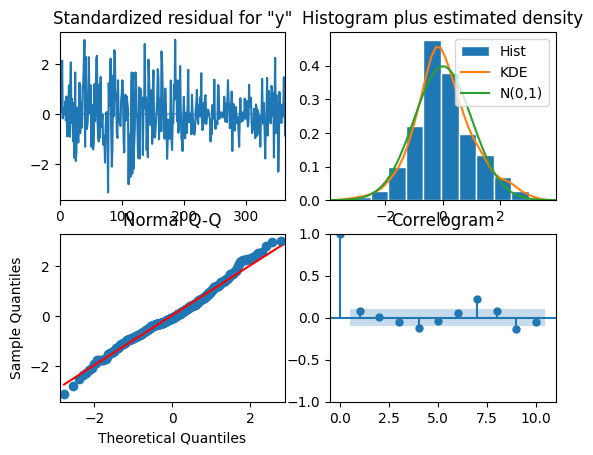

In [ ]:
impact.results.results.plot_diagnostics()

**Example: (avg) relative effect -12.8%**
--

/root/.ipykernel/1137/command-233991557695356-1019988831:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff.drop(['location_id', 'date', 'intervention'], inplace=True, axis=1)


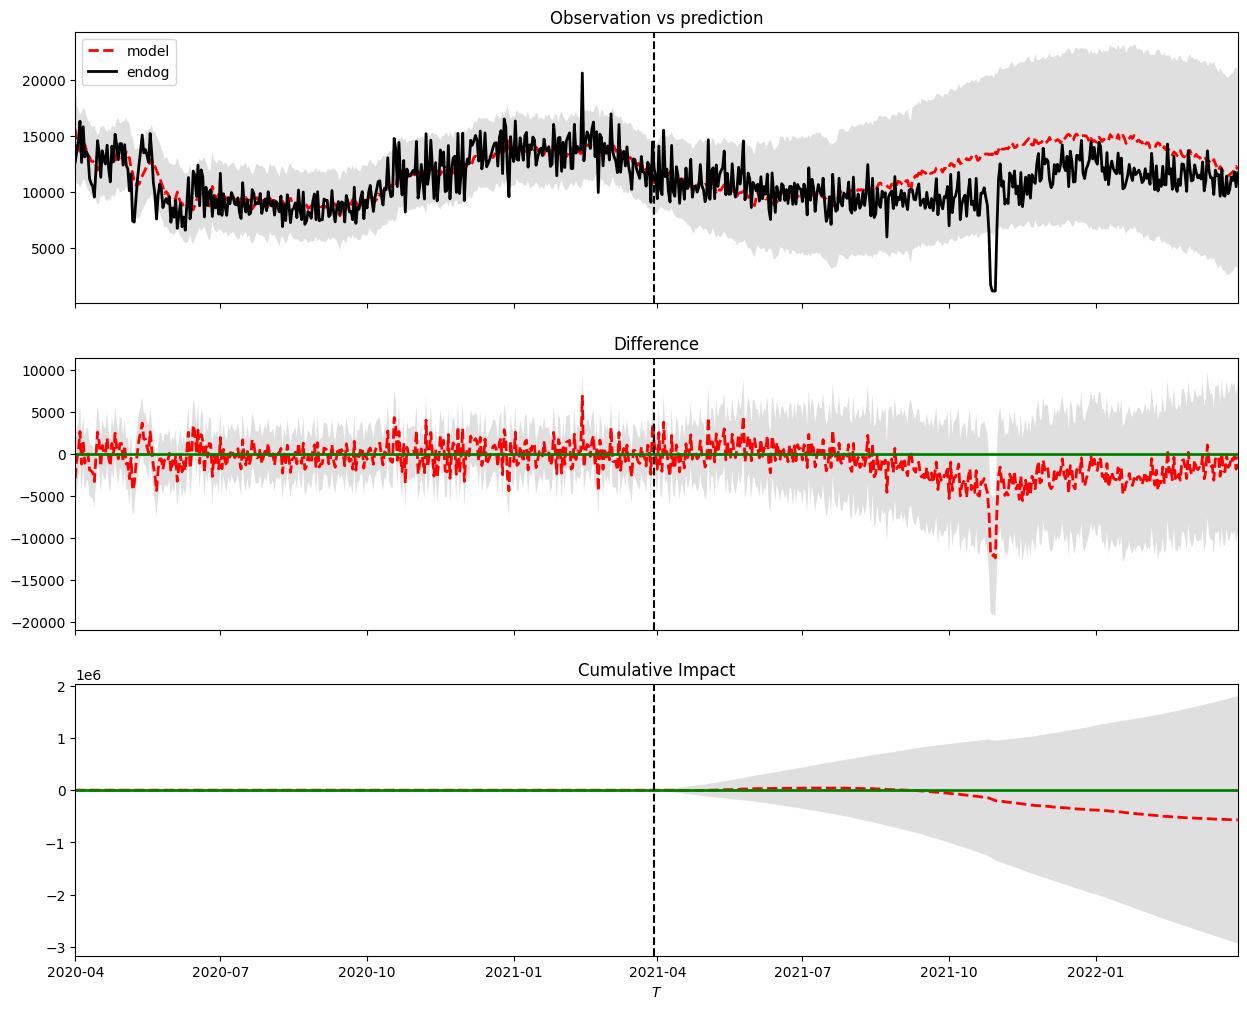

In [ ]:
df_diff = data.query(f'location_id=={1420066}')
df_diff.index = df_diff['date']
treatment_time = df_diff['intervention'].iloc[0]
pre_period_temp,post_period_temp  = df_diff[df_diff['date'] < treatment_time]['date'], df_diff[df_diff['date'] >= treatment_time]['date']
pre_period, post_period = [pre_period_temp.min(), pre_period_temp.max()], [post_period_temp.min(), post_period_temp.max()]
df_diff.drop(['location_id', 'date', 'intervention'], inplace=True, axis=1)
impact = CausalImpact(df_diff, pre_period, post_period)
impact.run()
impact.plot()

In [ ]:
impact.summary()

                                Average           Cumulative
Actual                            10535              3856093
Predicted                         12088              4424384
95% CI                    [5628, 18548]   [2060169, 6788600]
                                                            
Absolute Effect                   -1552              -568291
95% CI                    [4906, -8012]  [1795923, -2932507]
                                                            
Relative Effect                  -12.8%               -12.8%
95% CI                  [40.6%, -66.3%]      [40.6%, -66.3%]
                                                            
P-value                            0.0%                     
Prob. of Causal Effect           100.0%                     


**Example: (avg) relative effect -73.1% (min)**
--

/root/.ipykernel/1137/command-233991557695344-1954219826:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff.drop(['location_id', 'date', 'intervention'], inplace=True, axis=1)


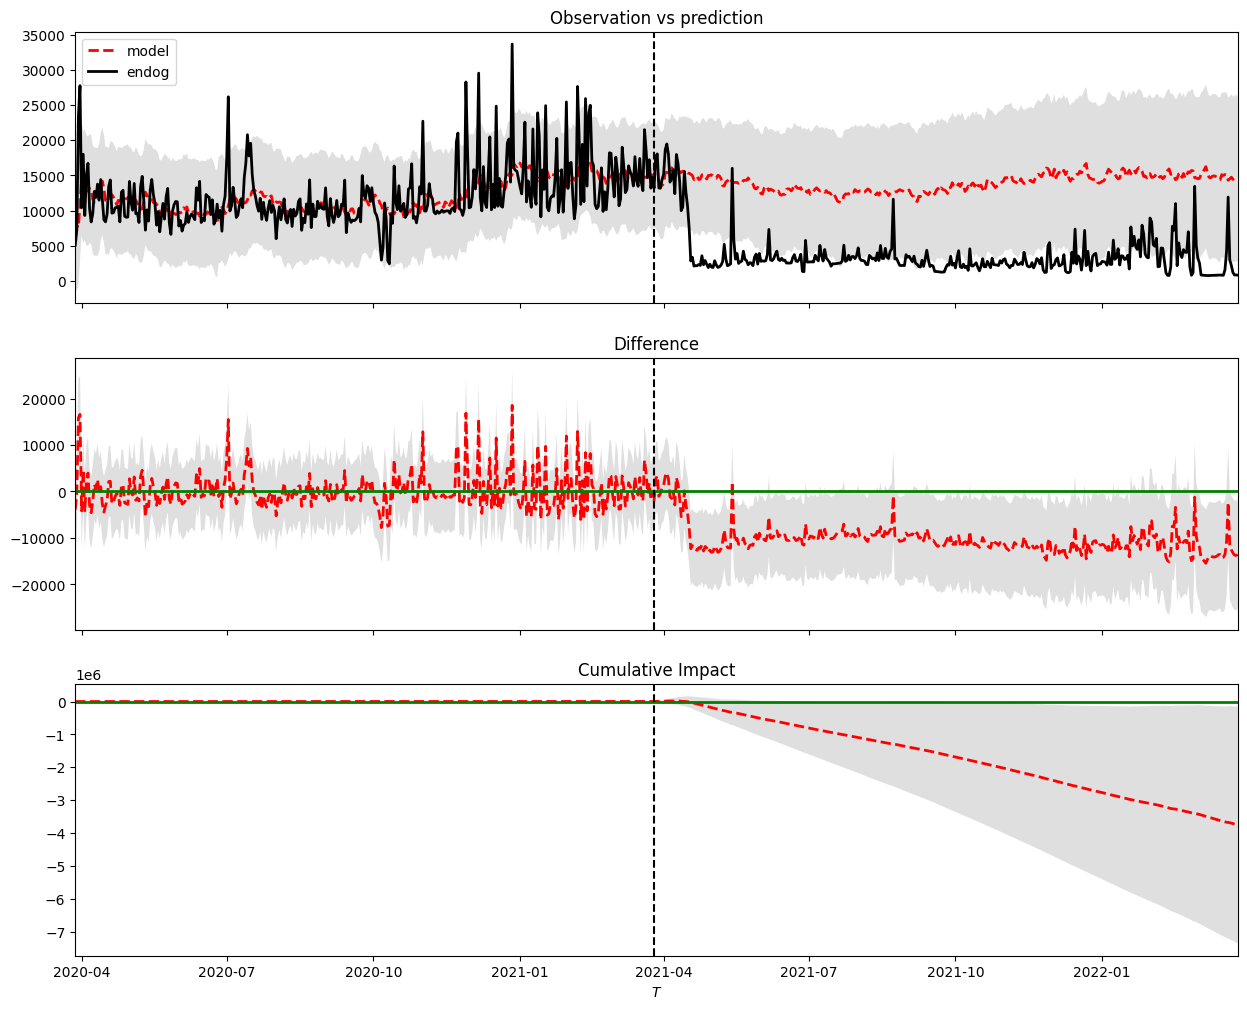

In [ ]:
df_diff = data.query(f'location_id=={1808360}')
df_diff.index = df_diff['date']
treatment_time = df_diff['intervention'].iloc[0]
pre_period_temp,post_period_temp  = df_diff[df_diff['date'] < treatment_time]['date'], df_diff[df_diff['date'] >= treatment_time]['date']
pre_period, post_period = [pre_period_temp.min(), pre_period_temp.max()], [post_period_temp.min(), post_period_temp.max()]
df_diff.drop(['location_id', 'date', 'intervention'], inplace=True, axis=1)
impact = CausalImpact(df_diff, pre_period, post_period)
impact.run()
impact.plot()

In [ ]:
impact.summary()

                                 Average           Cumulative
Actual                              3768              1379294
Predicted                          14021              5132006
95% CI                     [4180, 23863]   [1530143, 8733870]
                                                             
Absolute Effect                   -10253             -3752712
95% CI                    [-412, -20094]  [-150849, -7354576]
                                                             
Relative Effect                   -73.1%               -73.1%
95% CI                  [-2.9%, -143.3%]     [-2.9%, -143.3%]
                                                             
P-value                             0.3%                     
Prob. of Causal Effect             99.7%                     


**Example: (avg) relative effect 141% (max)**
--

/root/.ipykernel/1137/command-233991557695343-830273631:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff.drop(['location_id', 'date', 'intervention'], inplace=True, axis=1)


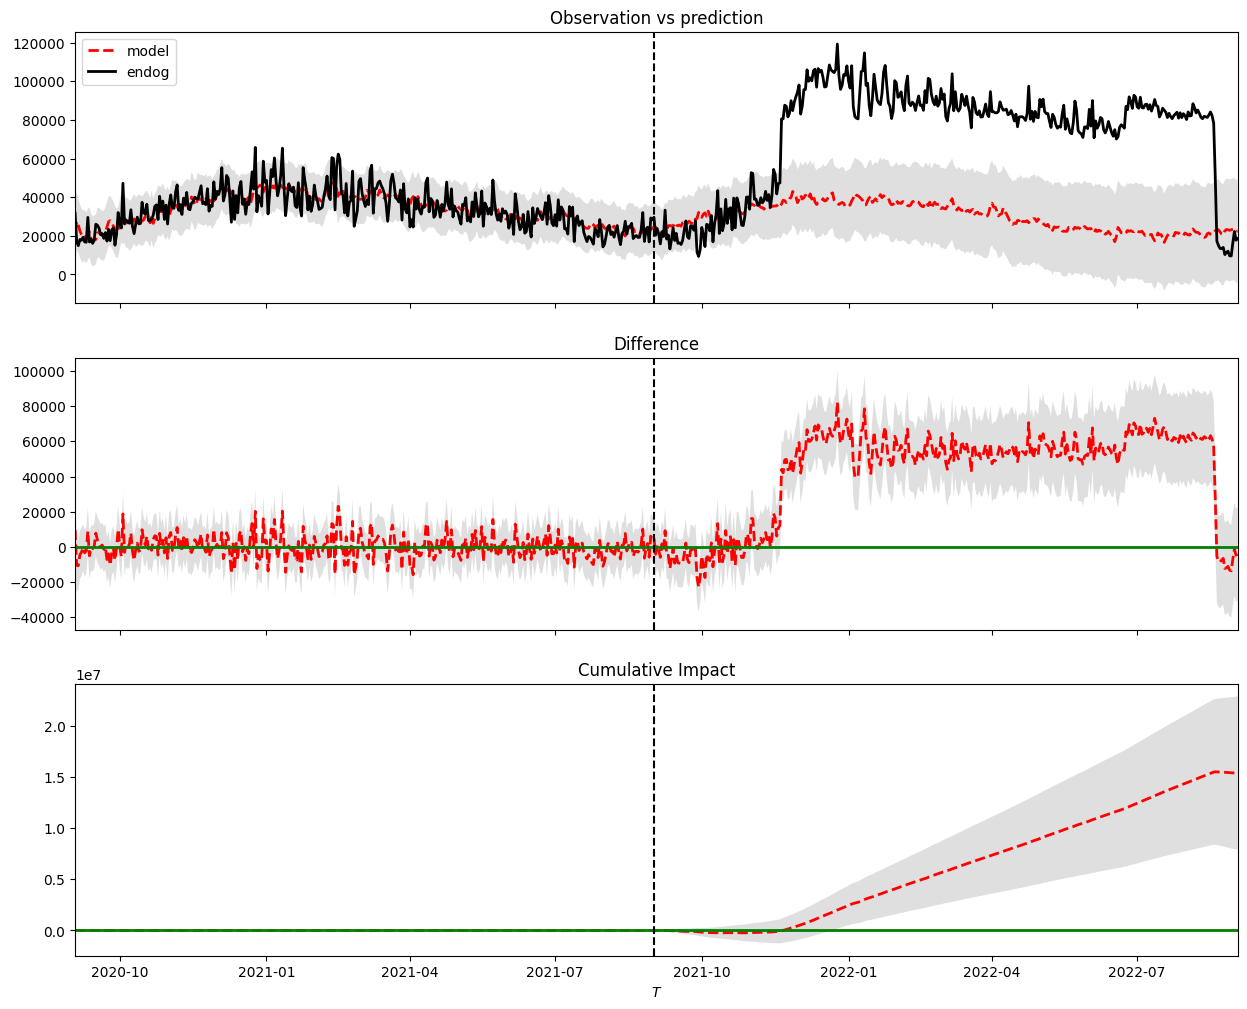

In [ ]:
df_diff = data.query(f'location_id=={1660366}')
df_diff.index = df_diff['date']
treatment_time = df_diff['intervention'].iloc[0]
pre_period_temp,post_period_temp  = df_diff[df_diff['date'] < treatment_time]['date'], df_diff[df_diff['date'] >= treatment_time]['date']
pre_period, post_period = [pre_period_temp.min(), pre_period_temp.max()], [post_period_temp.min(), post_period_temp.max()]
df_diff.drop(['location_id', 'date', 'intervention'], inplace=True, axis=1)
impact = CausalImpact(df_diff, pre_period, post_period)
impact.run()
impact.plot()

In [ ]:
impact.summary()

                                Average           Cumulative
Actual                            71849             26296967
Predicted                         29813             10911801
95% CI                    [9338, 50289]  [3417803, 18405799]
                                                            
Absolute Effect                   42035             15385165
95% CI                   [62511, 21560]  [22879163, 7891167]
                                                            
Relative Effect                  141.0%               141.0%
95% CI                  [209.7%, 72.3%]      [209.7%, 72.3%]
                                                            
P-value                            0.2%                     
Prob. of Causal Effect            99.8%                     


In [ ]:
# Convert pandas.DataFrame to PySpark DataFrame
results_spark_BSTS_1 = spark.createDataFrame(results)

In [ ]:
# Overview of results_spark_BSTS_1
results_spark_BSTS_1.show()
results_spark_BSTS_1.printSchema()

+-----------+----------------+-------------------+-------------------+----------------------+-----------------+--------------------+-------------------------+----------------------------+--------------------------------+-----------------------------------+-------------------------+----------------------------+--------------------------------+-----------------------------------+-------+----------------------+
|location_id|Actual (Average)|Actual (Cumulative)|Predicted (Average)|Predicted (Cumulative)| 95% CI (Average)| 95% CI (Cumulative)|Absolute Effect (Average)|Absolute Effect (Cumulative)|95% CI (Absolute Effect Average)|95% CI (Absolute Effect Cumulative)|Relative Effect (Average)|Relative Effect (Cumulative)|95% CI (Relative Effect Average)|95% CI (Relative Effect Cumulative)|P-value|Prob. of Causal Effect|
+-----------+----------------+-------------------+-------------------+----------------------+-----------------+--------------------+-------------------------+------------------

In [ ]:
# Renaming columns in PySpark DataFrame
curr_col = results.columns
new_col = [	'location_id','Actual_Average', 'Actual_Cumulative','Predicted_Average','Predicted_Cumulative','95_CI_Average','95_CI_Cumulative','Absolute_Effect_Average','Absolute_Effect_Cumulative','95_CI_Absolute_Effect_Average','95_CI_Absolute_Effect_Cumulative','Relative_Effect_Average','Relative_Effect_Cumulative','95_CI_Relative_Effect_Average','95_CI_Relative_Effect_Cumulative','Pvalue','Prob_of_Causal_Effect']
for old, new in zip(curr_col, new_col):
    results_spark_BSTS_1 = results_spark_BSTS_1.withColumnRenamed(old, new)

In [ ]:
# Save results_spark_BSTS_1 as jersey_results_BSTS_1 table in eliqdatalake.playground
results_spark_BSTS_1.write.saveAsTable("eliqdatalake.playground.jersey_results_BSTS_1", mode="overwrite")

In [ ]:
# Load jersey_results_BSTS_1
table_name = 'eliqdatalake.playground.jersey_results_BSTS_1'
query = f"SELECT * FROM {table_name}"
results_statistically_significant = spark.sql(query).toPandas().sort_values(['location_id']).reset_index(drop=True)

In [ ]:
results_statistically_significant

,location_id,Actual_Average,Actual_Cumulative,Predicted_Average,Predicted_Cumulative,95_CI_Average,95_CI_Cumulative,Absolute_Effect_Average,Absolute_Effect_Cumulative,95_CI_Absolute_Effect_Average,95_CI_Absolute_Effect_Cumulative,Relative_Effect_Average,Relative_Effect_Cumulative,95_CI_Relative_Effect_Average,95_CI_Relative_Effect_Cumulative,Pvalue,Prob_of_Causal_Effect
0,1420037,9384,3434891,9505,3478838,"[6315, 12694]","[2311375, 4646300]",-120,-43947,"[3069, -3309]","[1123515, -1211409]",-1.3,-1.3,"[32.3, -34.8]","[32.3, -34.8]",0.0,100.0
1,1420043,8520,3118457,8588,3143212,"[1999, 15176]","[731971, 5554453]",-67,-24755,"[6520, -6655]","[2386485, -2435996]",-0.8,-0.8,"[75.9, -77.5]","[75.9, -77.5]",0.5,99.5
2,1420059,13370,4893747,11099,4062301,"[669, 21528]","[245063, 7879539]",2271,831445,"[12701, -8157]","[4648683, -2985792]",20.5,20.5,"[114.4, -73.5]","[114.4, -73.5]",1.8,98.2
3,1420066,10535,3856093,12088,4424384,"[5628, 18548]","[2060169, 6788600]",-1552,-568291,"[4906, -8012]","[1795923, -2932507]",-12.8,-12.8,"[40.6, -66.3]","[40.6, -66.3]",0.0,100.0
4,1420072,16104,5894308,10625,3888998,"[-53579, 74830]","[-19610112, 27388109]",5478,2005309,"[69684, -58726]","[25504420, -21493801]",51.6,51.6,"[655.8, -552.7]","[655.8, -552.7]",37.3,62.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5006,5481719,549,200991,579,212055,"[24, 1134]","[9051, 415058]",-30,-11064,"[524, -584]","[191939, -214067]",-5.2,-5.2,"[90.5, -100.9]","[90.5, -100.9]",2.0,98.0
5007,5651511,6734,2464785,17136,6271935,"[-43100, 77372]","[-15774605, 28318476]",-10402,-3807150,"[49834, -70638]","[18239390, -25853691]",-60.7,-60.7,"[290.8, -412.2]","[290.8, -412.2]",28.9,71.1
5008,6061367,6740,2467173,13324,4876705,"[-30968, 57616]","[-11334344, 21087755]",-6583,-2409531,"[37709, -50875]","[13801518, -18620581]",-49.4,-49.4,"[283.0, -381.8]","[283.0, -381.8]",27.8,72.2
5009,6377801,19720,7217540,16115,5898178,"[-958, 33189]","[-350883, 12147241]",3604,1319361,"[20678, -13469]","[7568424, -4929700]",22.4,22.4,"[128.3, -83.6]","[128.3, -83.6]",3.2,96.8


[(-100.0, 100.0)]

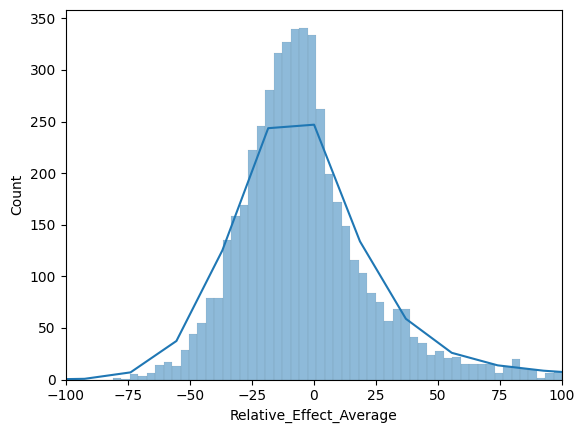

In [ ]:
# Histogram average relative effects
plot = sns.histplot(data=results_statistically_significant, x='Relative_Effect_Average', kde=True)
plot.set(xlim=(-100,100))

##### Tests

In [ ]:
data['location_id'].unique()[:10]

array([1420037, 1420043, 1420059, 1420066, 1420072, 1420073, 1420076,
       1420086, 1420088, 1420089])

In [ ]:
len(data['location_id'].unique())

5033

In [ ]:
df_diff = data.query(f'location_id=={1420059}')
df_diff.index = df_diff['date']
treatment_time = df_diff['intervention'].iloc[0]
pre_period_temp = df_diff[df_diff['date'] < treatment_time]['date']
post_period_temp = df_diff[df_diff['date'] >= treatment_time]['date']
pre_period = [pre_period_temp.min(), pre_period_temp.max()]
post_period = [post_period_temp.min(), post_period_temp.max()]
df_diff.drop(['location_id', 'date', 'intervention'], inplace=True, axis=1)
df_diff.shape

/root/.ipykernel/1115/command-2542499471654610-456644876:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff.drop(['location_id', 'date', 'intervention'], inplace=True, axis=1)


(731, 7)

In [ ]:
impact = CausalImpact(df_diff, pre_period, post_period)
impact.run()

In [ ]:
impact.inferences

,response,cum_response,point_pred,point_pred_lower,point_pred_upper,cum_pred,cum_pred_lower,cum_pred_upper,point_effect,point_effect_lower,point_effect_upper,cum_effect,cum_effect_lower,cum_effect_upper
date,,,,,,,,,,,,,,
2020-03-31,11443.0,11443.0,13871.771258,-5.453279e+06,5.481022e+06,1.387177e+04,-5.453279e+06,5.481022e+06,-2428.771258,5.464722e+06,-5.469579e+06,0.000000,0.000000e+00,0.000000e+00
2020-04-01,10140.0,21583.0,11046.252632,5.827845e+03,1.626466e+04,2.491802e+04,-5.447451e+06,5.497287e+06,-906.252632,4.312155e+03,-6.124660e+03,0.000000,0.000000e+00,0.000000e+00
2020-04-02,10784.0,32367.0,11055.346288,6.505854e+03,1.560484e+04,3.597337e+04,-5.440945e+06,5.512892e+06,-271.346288,4.278146e+03,-4.820838e+03,0.000000,0.000000e+00,0.000000e+00
2020-04-03,11991.0,44358.0,10519.890362,6.203033e+03,1.483675e+04,4.649326e+04,-5.434742e+06,5.527729e+06,1471.109638,5.787967e+03,-2.845747e+03,0.000000,0.000000e+00,0.000000e+00
2020-04-04,8635.0,52993.0,10654.356640,6.449151e+03,1.485956e+04,5.714762e+04,-5.428293e+06,5.542588e+06,-2019.356640,2.185849e+03,-6.224563e+03,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-27,8776.0,9609058.0,10758.215949,-3.946807e+03,2.546324e+04,8.775417e+06,-1.924100e+06,1.947493e+07,-1982.215949,1.272281e+04,-1.668724e+04,832365.174068,4.590595e+06,-2.925865e+06
2022-03-28,11118.0,9620176.0,11263.611709,-3.460226e+03,2.598745e+04,8.786680e+06,-1.927560e+06,1.950092e+07,-145.611709,1.457823e+04,-1.486945e+04,832219.562359,4.605173e+06,-2.940734e+06
2022-03-29,9444.0,9629620.0,11525.891974,-3.216737e+03,2.626852e+04,8.798206e+06,-1.930777e+06,1.952719e+07,-2081.891974,1.266074e+04,-1.682452e+04,830137.670386,4.617834e+06,-2.957559e+06


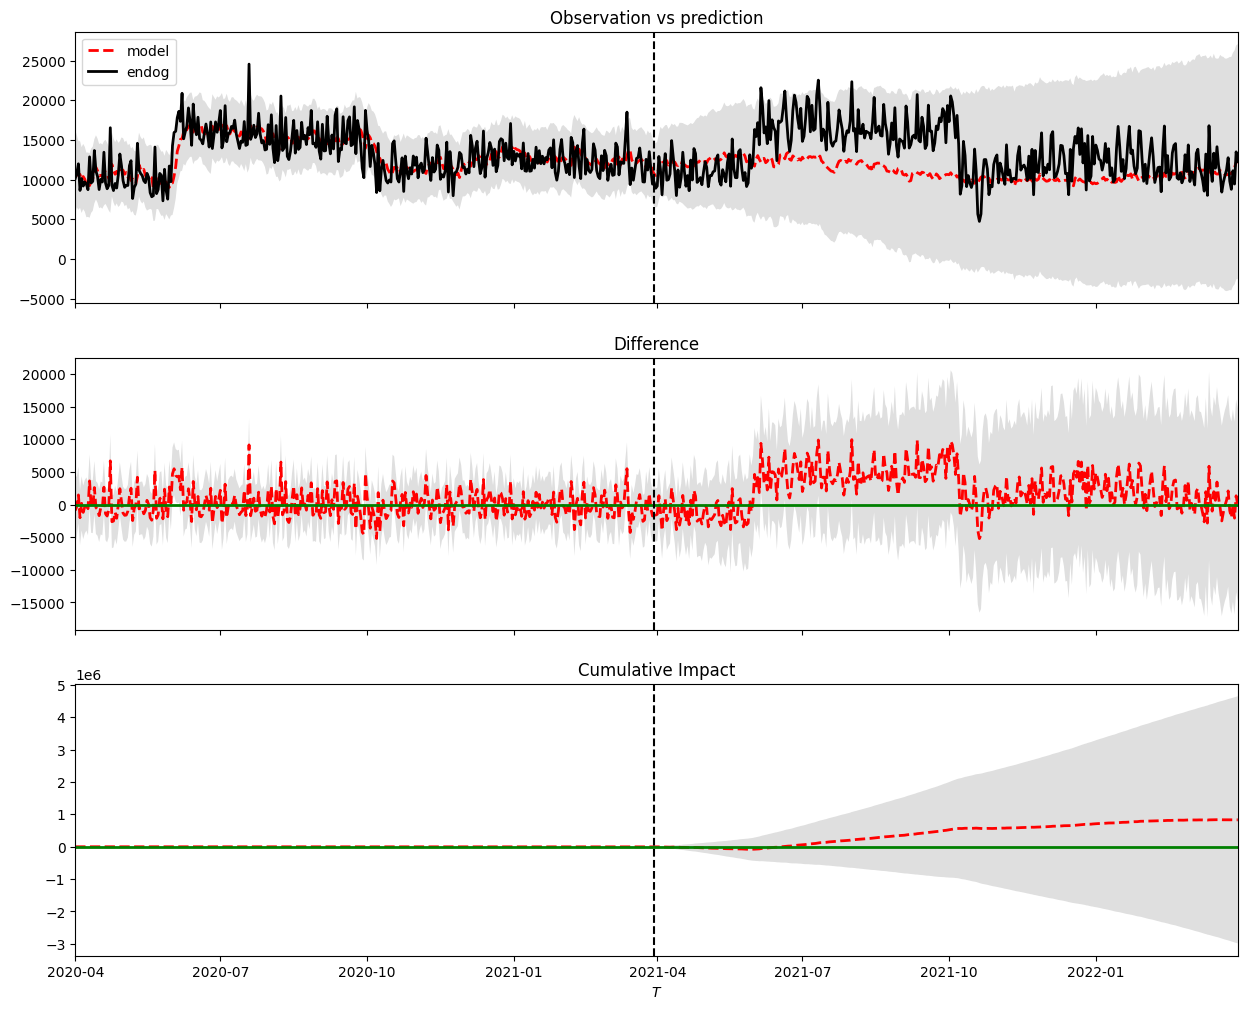

In [ ]:
impact.plot()

In [ ]:
impact.summary()

                                 Average           Cumulative
Actual                             13370              4893747
Predicted                          11099              4062301
95% CI                      [669, 21528]    [245063, 7879539]
                                                             
Absolute Effect                     2271               831445
95% CI                    [12701, -8157]  [4648683, -2985792]
                                                             
Relative Effect                    20.5%                20.5%
95% CI                  [114.4%, -73.5%]     [114.4%, -73.5%]
                                                             
P-value                             1.8%                     
Prob. of Causal Effect             98.2%                     


In [ ]:
impact.summary(output='report')

During the post-intervention period, the response             variable had an average value of             approx.
13370.  By contrast, in  the absence of an intervention, we would have expected an average response of 11099. The 95%
interval of this counterfactual prediction is [669, 21528]. Subtracting this prediction from the observed response
yields an estimate of the causal effect the intervention had on the response variable. This effect is 2271 with a 95%
interval of [12701, -8157]. For a discussion of the significance of this effect, see below.


 Summing up the individual data points during the post-intervention period (which can only sometimes be meaningfully
interpreted), the response variable had an overall value of 4893747.  By contrast, had  the intervention not taken
place, we would have expected a sum of 4062301. The 95% interval of this prediction is [245063, 7879539]


 The above results are given in terms of absolute numbers. In relative terms, the response variable s

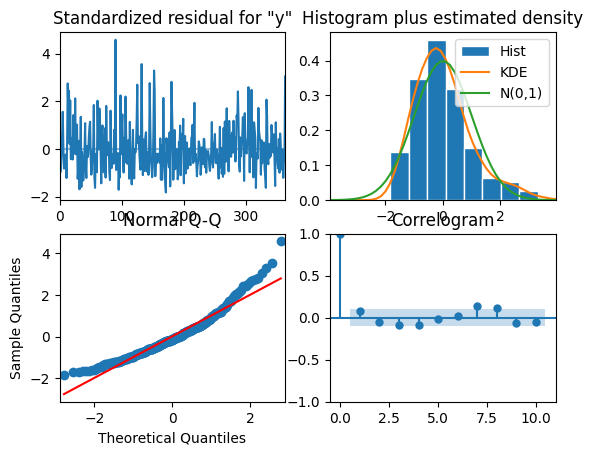

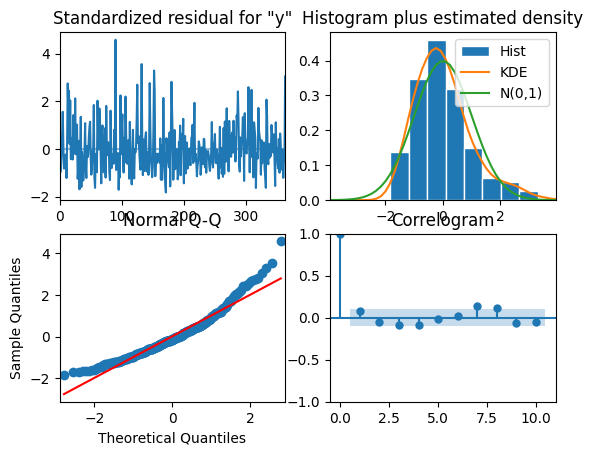

In [ ]:
impact.results.results.plot_diagnostics()

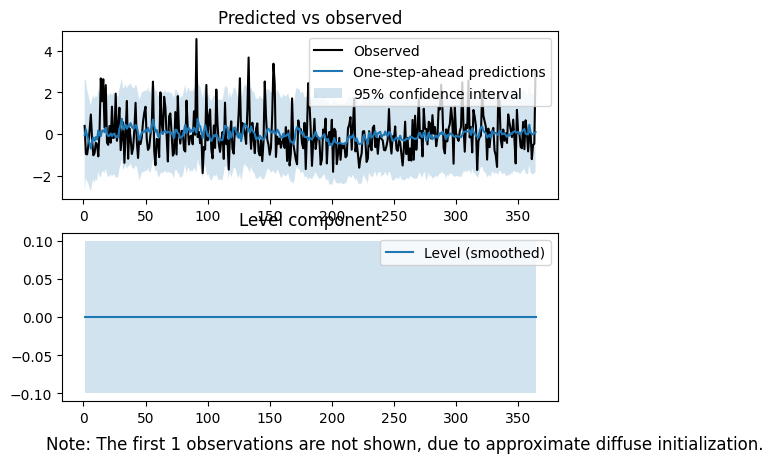

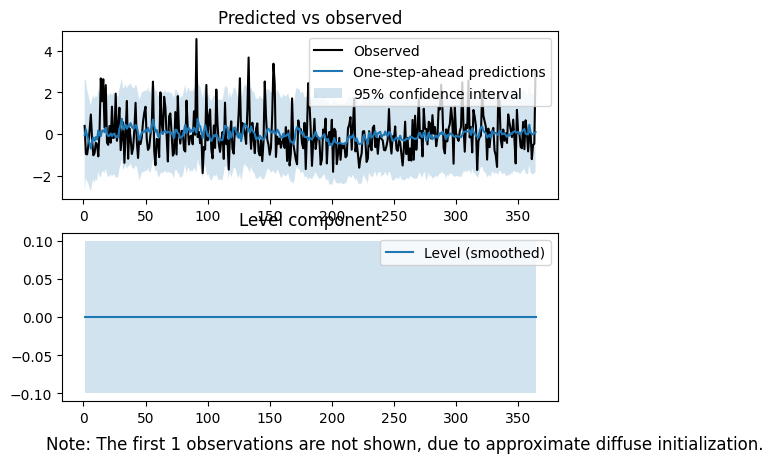

In [ ]:
impact.results.results.plot_components()

In [ ]:
placeholder = data[data['location_id'].isin([1420037, 1420043, 1420059, 1420066, 1420072, 1420073, 1420076, 1420086, 1420088, 1420089])]
placeholder

,location_id,date,intervention,energy,temp,cloudcover,humidity,precip,windspeed,brightness_s2s
0,1420037,2020-09-20,2021-09-20,9429.0,18.6,17.0,86.0,0.0,12.2,0.41
1,1420037,2020-09-21,2021-09-20,10173.0,18.9,11.0,84.0,0.0,12.5,0.41
2,1420037,2020-09-22,2021-09-20,7932.0,17.1,42.0,93.0,0.0,13.5,0.40
3,1420037,2020-09-23,2021-09-20,7901.0,15.3,38.0,84.0,0.1,28.0,0.40
4,1420037,2020-09-24,2021-09-20,8638.0,12.5,36.0,77.0,0.2,40.4,0.40
...,...,...,...,...,...,...,...,...,...,...
7305,1420089,2022-03-27,2021-03-31,8125.0,11.4,7.0,75.0,0.0,23.2,0.42
7306,1420089,2022-03-28,2021-03-31,6207.0,11.8,44.0,77.0,0.0,17.5,0.43
7307,1420089,2022-03-29,2021-03-31,5764.0,11.4,67.0,86.0,0.1,15.1,0.43
7308,1420089,2022-03-30,2021-03-31,7537.0,8.7,85.0,89.0,0.0,15.3,0.44


In [ ]:
results = BSTS_model(placeholder)

In [ ]:
results

,location_id,Actual (Average),Actual (Cumulative),Predicted (Average),Predicted (Cumulative),95% CI (Average),95% CI (Cumulative),Absolute Effect (Average),Absolute Effect (Cumulative),95% CI (Absolute Effect Average),95% CI (Absolute Effect Cumulative),Relative Effect (Average),Relative Effect (Cumulative),95% CI (Relative Effect Average),95% CI (Relative Effect Cumulative),P-value,Prob. of Causal Effect
0,1420037,9384,3434891,9505,3478838,"[6315, 12694]","[2311375, 4646300]",-120,-43947,"[3069, -3309]","[1123515, -1211409]",-1.3,-1.3,"[32.3, -34.8]","[32.3, -34.8]",0.0,100.0
1,1420043,8520,3118457,8588,3143212,"[1999, 15176]","[731971, 5554453]",-67,-24755,"[6520, -6655]","[2386485, -2435996]",-0.8,-0.8,"[75.9, -77.5]","[75.9, -77.5]",0.5,99.5
2,1420059,13370,4893747,11099,4062301,"[669, 21528]","[245063, 7879539]",2271,831445,"[12701, -8157]","[4648683, -2985792]",20.5,20.5,"[114.4, -73.5]","[114.4, -73.5]",1.8,98.2
3,1420066,10535,3856093,12088,4424384,"[5628, 18548]","[2060169, 6788600]",-1552,-568291,"[4906, -8012]","[1795923, -2932507]",-12.8,-12.8,"[40.6, -66.3]","[40.6, -66.3]",0.0,100.0
4,1420072,16104,5894308,10625,3888998,"[-53579, 74830]","[-19610112, 27388109]",5478,2005309,"[69684, -58726]","[25504420, -21493801]",51.6,51.6,"[655.8, -552.7]","[655.8, -552.7]",37.3,62.7
5,1420073,12025,4401233,12286,4496973,"[5092, 19481]","[1863705, 7130241]",-261,-95739,"[6933, -7456]","[2537527, -2729007]",-2.1,-2.1,"[56.4, -60.7]","[56.4, -60.7]",0.0,100.0
6,1420076,50021,18307888,48567,17775820,"[-160627, 257762]","[-58789550, 94341191]",1453,532067,"[210648, -207741]","[77097438, -76033303]",3.0,3.0,"[433.7, -427.7]","[433.7, -427.7]",32.5,67.5
7,1420086,19473,7127146,24428,8940928,"[-22310, 71167]","[-8165605, 26047462]",-4955,-1813781,"[41783, -51694]","[15292752, -18920315]",-20.3,-20.3,"[171.0, -211.6]","[171.0, -211.6]",15.3,84.7
8,1420088,9326,3413598,9169,3356106,"[1168, 17170]","[427644, 6284567]",157,57491,"[8158, -7844]","[2985953, -2870969]",1.7,1.7,"[89.0, -85.5]","[89.0, -85.5]",1.2,98.8
9,1420089,6575,2406796,6933,2537506,"[2780, 11085]","[1017730, 4057282]",-357,-130710,"[3795, -4509]","[1389065, -1650486]",-5.2,-5.2,"[54.7, -65.0]","[54.7, -65.0]",0.1,99.9


In [ ]:
type(results['P-value'].loc[0])

numpy.float64

In [ ]:
results.query('`P-value` <= 5')

,location_id,Actual (Average),Actual (Cumulative),Predicted (Average),Predicted (Cumulative),95% CI (Average),95% CI (Cumulative),Absolute Effect (Average),Absolute Effect (Cumulative),95% CI (Absolute Effect Average),95% CI (Absolute Effect Cumulative),Relative Effect (Average),Relative Effect (Cumulative),95% CI (Relative Effect Average),95% CI (Relative Effect Cumulative),P-value,Prob. of Causal Effect
0,1420037,9384,3434891,9505,3478838,"[6315, 12694]","[2311375, 4646300]",-120,-43947,"[3069, -3309]","[1123515, -1211409]",-1.3,-1.3,"[32.3, -34.8]","[32.3, -34.8]",0.0,100.0
1,1420043,8520,3118457,8588,3143212,"[1999, 15176]","[731971, 5554453]",-67,-24755,"[6520, -6655]","[2386485, -2435996]",-0.8,-0.8,"[75.9, -77.5]","[75.9, -77.5]",0.5,99.5
2,1420059,13370,4893747,11099,4062301,"[669, 21528]","[245063, 7879539]",2271,831445,"[12701, -8157]","[4648683, -2985792]",20.5,20.5,"[114.4, -73.5]","[114.4, -73.5]",1.8,98.2
3,1420066,10535,3856093,12088,4424384,"[5628, 18548]","[2060169, 6788600]",-1552,-568291,"[4906, -8012]","[1795923, -2932507]",-12.8,-12.8,"[40.6, -66.3]","[40.6, -66.3]",0.0,100.0
5,1420073,12025,4401233,12286,4496973,"[5092, 19481]","[1863705, 7130241]",-261,-95739,"[6933, -7456]","[2537527, -2729007]",-2.1,-2.1,"[56.4, -60.7]","[56.4, -60.7]",0.0,100.0
8,1420088,9326,3413598,9169,3356106,"[1168, 17170]","[427644, 6284567]",157,57491,"[8158, -7844]","[2985953, -2870969]",1.7,1.7,"[89.0, -85.5]","[89.0, -85.5]",1.2,98.8
9,1420089,6575,2406796,6933,2537506,"[2780, 11085]","[1017730, 4057282]",-357,-130710,"[3795, -4509]","[1389065, -1650486]",-5.2,-5.2,"[54.7, -65.0]","[54.7, -65.0]",0.1,99.9


In [ ]:
df_prova = data.query(f'location_id=={1420066}')
for location_id, group in df_prova.groupby('location_id'):
    treatment_time = group['intervention'].iloc[0]
    pre_period = [group.loc[group['date'] < treatment_time, 'date'].min(), group.loc[group['date'] < treatment_time, 'date'].max()]
    post_period = [group.loc[group['date'] >= treatment_time, 'date'].min(), group.loc[group['date'] >= treatment_time, 'date'].max()]
    group.index = group['date']
    #group.drop(['location_id', 'date', 'intervention'], inplace=True, axis=1)
    #print('Treatment period:', treatment_time)
    #print('pre period ', pre_period)
    #print('post period ', post_period)
    #print(group)

    #treatment_time = group['intervention'].iloc[0]
    #group.reset_index(inplace=True)
    #pre_treatment_tot, post_treatment_tot = group.loc[group['date'] < treatment_time, 'date'].index, group.loc[group['date'] >= treatment_time, 'date'].index
    #pre_period, post_period = [pre_treatment_tot.min(), pre_treatment_tot.max()], [post_treatment_tot.min(), post_treatment_tot.max()]
    #print(pre_period, post_period)
    # Drop location_id, date and intervention before applying causalimpact
    group.drop(['location_id', 'date', 'intervention', 'temp', 'cloudcover', 'humidity', 'precip', 'windspeed', 'brightness_s2s'], inplace=True, axis=1)
    # Apply causalimpact
    impact = CausalImpact(group, pre_period, post_period, estimation='pymc')
    impact.run()

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-2159506188393796>, line 22
     20 # Apply causalimpact
     21 impact = CausalImpact(group, pre_period, post_period, estimation='pymc')
---> 22 impact.run()

File /local_disk0/.ephemeral_nfs/envs/pythonEnv-cff94633-5faf-48ef-801f-97b5596bc8ca/lib/python3.10/site-packages/causalimpact/analysis.py:103, in CausalImpact.run(self)
    101 # Depending on input, dispatch to the appropriate Run* method()
    102 if self.data is not None:
--> 103     self._run_with_data(
    104         kwargs["data"],
    105         kwargs["pre_period"],
    106         kwargs["post_period"],
    107         kwargs["model_args"],
    108         kwargs["alpha"],
    109         self.params["estimation"],
    110     )
    111 else:
    112     self._run_with_ucm(
    113         kwargs["ucm_model"],
    114         kwargs["post_period_response"]

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import arma_generate_sample
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 6)

np.random.seed(1)

x1 = arma_generate_sample(ar=[0.999], ma=[0.9], nsample=100) + 100
y = 1.2 * x1 + np.random.randn(100)
y[71:100] = y[71:100] + 10
data = pd.DataFrame(np.array([y, x1]).T, columns=["y","x1"])
pre_period = [0,69]
post_period = [71,99]

In [ ]:
data

,y,x1
0,121.308920,101.463374
1,120.563149,99.448868
2,119.832495,99.524170
3,119.433612,99.033362
4,119.840664,100.779647
...,...,...
95,128.456173,100.069676
96,130.230586,99.690222
97,130.467414,100.039276
98,130.140680,99.441441


In [ ]:
bayes_impact = CausalImpact(data, pre_period, post_period, estimation="pymc", model_args={"ndraws":3000, "nburn":300})
bayes_impact.run()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma2.irregular, sigma2.level, beta.x1]


Sampling 4 chains for 300 tune and 3_000 draw iterations (1_200 + 12_000 draws total) took 31 seconds.


In [ ]:
bayes_impact.summary()

                              Average     Cumulative
Actual                            130           3784
Predicted                         119           3472
95% CI                     [112, 127]   [3252, 3692]
                                                    
Absolute Effect                    10            312
95% CI                        [18, 3]      [532, 91]
                                                    
Relative Effect                  9.0%           9.0%
95% CI                  [15.3%, 2.6%]  [15.3%, 2.6%]
                                                    
P-value                          0.0%               
Prob. of Causal Effect         100.0%               
